# Using EcoFOCIpy to apply Data Filters to 1D data

- filter examples:
    - 35hr Lanzcos Filter **good for data with tides like ADCP**
    - IQR (inter-quartile range) filter
    - STD (standard deviation) filter
    - 7pt rolling mean-value exceeds 5std of timeseries demeaned data **good for spiky data like chlor, sal in interface** and should be applied when there is a seasonal baseline shift (duration of rolling mean?) *TODO: make subroutine and output flag to variables*
    
    
- input:
    - timeseries data
- output:
    - timeseries data, flags
    
TODO:
- linearly fill (foward or back?) no more than x number of points (likely 1) -> interp_na(limit=1)
- output to xarray modified netcdf file

List of instruments filtered here:
   + 17bsm2a_sc_0001m (UAF)
   + 17bsm2a_sc_0006m
   + 17bsm2a_sc_0044m
   + 17bsm2a_s37_0024m

In [54]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
import datetime

import EcoFOCIpy.math.cleaning as cleaning #<- instrument specific
import EcoFOCIpy.math.lanzcos as lanzcos #<- instrument specific

In [58]:
# testfile = '../staticdata/example_data/nc_data/16bsm2a_eco_0000m.nc'
testfile = '/Users/bell/ecoraid/2017/Moorings/17bsm2a/working/17bsm2a_s37_0024m.unqcd.trimmed_missing.cf.nc'

So lets load a timeseries and apply filters to the entire period

In [59]:
var_choice = 'S_41'

In [60]:
xdf = xa.load_dataset(testfile)


#data without flags or set to large numbers... especially if not nan or EPIC, don't change flag as it may already be set
xdf = xdf.where(xdf<1e20,np.nan)


#these pre filter QC flags should all be set to QC #4
xdf['S_41'] = xdf.S_41.where((xdf.S_41>30) & (xdf.S_41<35),np.nan)
xdf['S_41'] = xdf.S_41.where((xdf.T_20>-2) & (xdf.T_20<30),np.nan)
xdf['T_20'] = xdf.T_20.where((xdf.T_20>-2) & (xdf.T_20<30),np.nan)



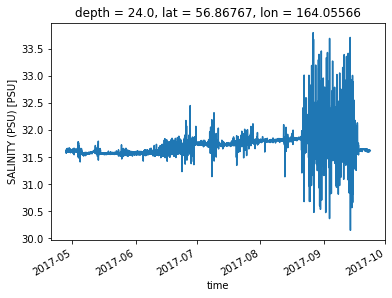

In [61]:
xdf[var_choice].plot()

In [62]:
df = xdf[var_choice][:,0,0,0].to_dataframe().drop(labels=['depth','lat','lon'],axis=1)
# dft = df.dropna()
dft=df
#
## missing data fill limited by number of hours to linearly interpolate
temp = dft[var_choice].interpolate(method='time',limit=6)

# get index of missing data that wasn't filled
# the remaining missing data will continue to be missing after analysis
# this data and the edges of the timeseries need to have the effects of the filter window accounted for

missing_index = np.isnan(temp)
temp = dft[var_choice].interpolate(method='time')

#address gaps at beginning and end... back fill... and forward fill at end... 
# the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
temp.bfill(inplace=True)
temp.ffill(inplace=True)

#filter data with lanzcos filter
lanzcosfiltered = lanzcos.lanzcos(temp.values,1,35) + dft[var_choice].mean()

In [63]:
IQRcleaned = cleaning.outlier_bounds_iqr(xdf[var_choice])
STDcleaned = cleaning.outlier_bounds_std(xdf[var_choice])

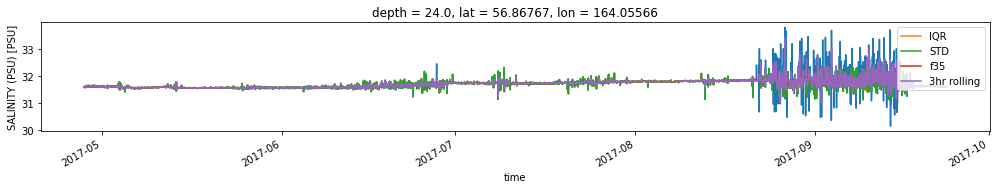

In [64]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)

ax.legend()


But perhaps a form of rolling std/iqr filter is more appropriate as it wont tend to mask relevant peaks by being a median filter

*Finally* try to refill as many points back to the start and finish of the 

In [65]:
N=3
clean = cleaning.rolling_outlier_std(xdf,var_choice,timebase=N*2+1,stddev=5,interp_fill_timebase='2H') 
#TODO? timebase is not endpoint inclusive... if you want to fill 1hour then choose a value bigger like 2hours which wont fill 2hour gaps

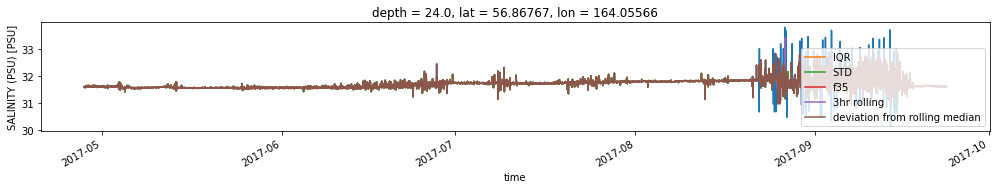

In [66]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)
clean[var_choice].plot(label='deviation from rolling median', ax=ax)

ax.legend()


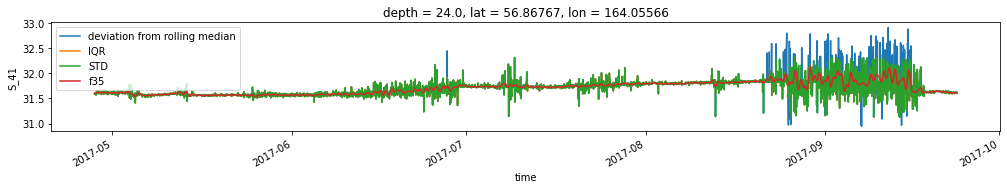

In [67]:
fig, ax = plt.subplots(figsize=(17, 2))

clean[var_choice].plot(label='deviation from rolling median', ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)

ax.legend()


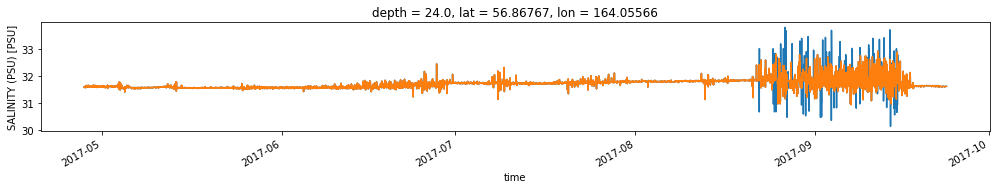

In [68]:
fig, ax = plt.subplots(figsize=(17, 2))
xdf[var_choice].plot(ax=ax)
clean[var_choice].plot(label='deviation from rolling median',ax=ax)


(array([7042.,   10.,    0.,    0.,    0.,   22.,    0.,    0.,    0.,
          69.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

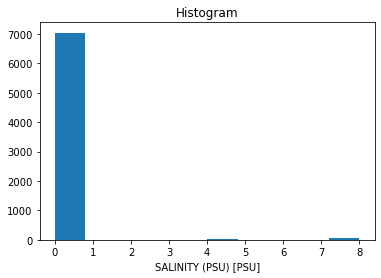

In [69]:
clean[var_choice+'_QC'].plot.hist()

In [70]:
clean.to_dataframe().to_csv(testfile.replace('.nc','.'+var_choice+'.despiked.csv'))